# 1. Load Library

In this section we import all the necessary libraries.

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import pickle
# from xgboost import XGBRegressor                  # XGBoost for GPU processing
from sklearn.preprocessing import OneHotEncoder     # Support Sparse Matrix
print('Libraries loaded successfully')

Libraries loaded successfully


/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Load Original Dataset

## Exploring the dataset by using packages

In [5]:
# Download from Kaggle or load preprocessed data
current_path = None
if not current_path:
    path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

    files = os.listdir(path)
    csv_path = os.path.join(path, 'GDSC_Cleaned.csv')
    df = pd.read_csv(csv_path)
    df.head()
else:
    path = current_path
    with open(os.path.join(path, 'GDSC_Cleaned.pkl'), 'rb') as f:
        df = pickle.load(f)

print("Path to dataset files:", path)

Path to dataset files: /Users/shijie/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [6]:
df.head()

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.592660,-1.516647,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.734047,-0.807232,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-3.452815,0.582439,-1.570016,bone,ewings_sarcoma,LUAD,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


In [7]:
df.shape

(214880, 19)

In [8]:
# check all columns unique values length
def check_unique_values(df):
    for col in df.columns:
        unique_values = df[col].nunique()
        print(f"Column '{col}' has {unique_values} unique values.")
check_unique_values(df)

Column 'COSMIC_ID' has 969 unique values.
Column 'CELL_LINE_NAME' has 969 unique values.
Column 'TCGA_DESC' has 32 unique values.
Column 'DRUG_ID' has 257 unique values.
Column 'DRUG_NAME' has 249 unique values.
Column 'LN_IC50' has 200401 unique values.
Column 'AUC' has 133567 unique values.
Column 'Z_SCORE' has 208199 unique values.
Column 'GDSC Tissue descriptor 1' has 19 unique values.
Column 'GDSC Tissue descriptor 2' has 54 unique values.
Column 'Cancer Type (matching TCGA label)' has 31 unique values.
Column 'Microsatellite instability Status (MSI)' has 2 unique values.
Column 'Screen Medium' has 2 unique values.
Column 'Growth Properties' has 3 unique values.
Column 'CNA' has 2 unique values.
Column 'Gene Expression' has 2 unique values.
Column 'Methylation' has 2 unique values.
Column 'TARGET' has 185 unique values.
Column 'TARGET_PATHWAY' has 24 unique values.


In [9]:
# Data preprocessing
categorical_features = ['GDSC Tissue descriptor 1',
                        'GDSC Tissue descriptor 2', 'Cancer Type (matching TCGA label)']
full_features = categorical_features + ['Microsatellite instability Status (MSI)', 'CNA', 'Gene Expression', 'Methylation']

data = df.copy()
# Filter highly skewed drugs: skewness of LN_IC50 should be ≤ 2
drug_skew = data.groupby("DRUG_NAME")["LN_IC50"].skew()
abs_skews = drug_skew.abs()
threshold = 2
low_skew_drugs = abs_skews[abs_skews <= threshold].index
data_filtered = data[data["DRUG_NAME"].isin(low_skew_drugs)].copy()
print(f"Using absolute skewness ≤ {threshold:.2f} as low‑skew cutoff.")
all_drugs = data["DRUG_NAME"].unique()
print(f"Filter {len(all_drugs) - len(low_skew_drugs)} drugs.")

# Drop rows with TARGET_PATHWAY=other or other, kinase
data_filtered = data_filtered[~data_filtered['TARGET_PATHWAY'].isin(['Other', 'Other, kinases'])]

X = data_filtered[full_features]
# X = data_filtered[categorical_features]

# One-Hot Encoding for X
X_encoder = OneHotEncoder(sparse_output=True)
X_encoded = X_encoder.fit_transform(X)
# X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

y = data_filtered["LN_IC50"]
print(y.value_counts())

Using absolute skewness ≤ 2.00 as low‑skew cutoff.
Filter 6 drugs.
LN_IC50
-3.452815    5763
 9.622963      24
 5.063109       8
 6.417191       8
 4.976861       8
             ... 
 5.047957       1
 4.725636       1
 2.888847       1
 2.868932       1
 8.259562       1
Name: count, Length: 164234, dtype: int64


## Cluster

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


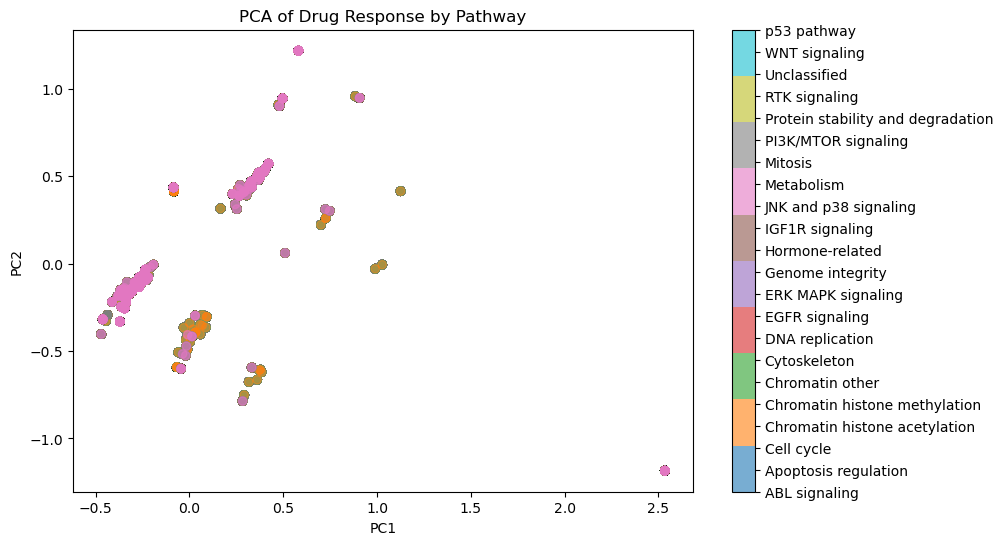

In [10]:
# cluster the targets without IDs by k-means
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_encoded.toarray())
# Create a DataFrame with PCA results
pathway_cat = pd.Categorical(data_filtered['TARGET_PATHWAY'])
pca_df = pd.DataFrame(
    X_pca, 
    columns=['PC1','PC2'], 
    index=data_filtered.index)
pca_df['ClusterCode'] = pathway_cat.codes
# Plot PCA results
plt.figure(figsize=(10,6))
sc = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=pca_df['ClusterCode'], 
    cmap='tab10',
    alpha=0.6
)

# Add color bar
cbar = plt.colorbar(sc, ticks=range(len(pathway_cat.categories)))
cbar.ax.set_yticklabels(pathway_cat.categories)

plt.title('PCA of Drug Response by Pathway')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [34]:
import numpy as np
import pandas as pd

feature_names = X_encoder.get_feature_names_out()

# Get the PCA components
components_df = pd.DataFrame(
    pca.components_, 
    columns=feature_names,
    index=['PC1', 'PC2']
)

# check the components
for pc in ['PC1', 'PC2']:
    print(f"\n{pc} most important features:")
    display(components_df.loc[pc].abs().sort_values(ascending=False).head(10))



PC1 most important features:


Cancer Type (matching TCGA label)_LUAD    0.552198
Methylation_Y                             0.296970
Gene Expression_Y                         0.285603
CNA_Y                                     0.268990
Gene Expression_nan                       0.267814
CNA_nan                                   0.267814
Methylation_nan                           0.267814
GDSC Tissue descriptor 1_nan              0.267814
GDSC Tissue descriptor 2_nan              0.267814
GDSC Tissue descriptor 1_lung_NSCLC       0.130664
Name: PC1, dtype: float64


PC2 most important features:


Cancer Type (matching TCGA label)_LUAD                0.506516
GDSC Tissue descriptor 1_lung_NSCLC                   0.453151
GDSC Tissue descriptor 2_lung_NSCLC_adenocarcinoma    0.331203
Methylation_Y                                         0.231147
Gene Expression_Y                                     0.226401
CNA_Y                                                 0.199119
GDSC Tissue descriptor 1_nan                          0.192434
GDSC Tissue descriptor 2_nan                          0.192434
Methylation_nan                                       0.192434
Gene Expression_nan                                   0.192434
Name: PC2, dtype: float64

In [7]:
df['TARGET_PATHWAY'].value_counts()

TARGET_PATHWAY
PI3K/MTOR signaling                  22724
Other                                20659
Other, kinases                       17277
DNA replication                      16216
ERK MAPK signaling                   13350
Genome integrity                     12221
Cell cycle                           11620
Apoptosis regulation                 10828
Chromatin histone methylation        10612
RTK signaling                        10573
Chromatin histone acetylation         8162
Chromatin other                       7859
WNT signaling                         7631
Protein stability and degradation     7087
EGFR signaling                        6734
Mitosis                               6453
IGF1R signaling                       5512
Metabolism                            4802
Hormone-related                       3820
p53 pathway                           3776
Cytoskeleton                          3387
JNK and p38 signaling                 1905
ABL signaling                          

# Load training dataset

In [13]:
from dataloader import load_gdsc, prepare_features, split_data
excluded_columns = ['LN_IC50', 'AUC', 'Z_SCORE', 'DRUG_ID', 'COSMIC_ID', 'DRUG_NAME', 'CELL_LINE_NAME']
df = load_gdsc(excluded_columns=excluded_columns)   # With Drop NaN & Exclude Outlier with IQR

# Create dummy variables for categorical features and split the data into training and testing sets with default test size of 0.2
X_dummy, y = prepare_features(df, encode_dummies=True)
X_label, _ = prepare_features(df, encode_dummies=False)
Xd_tr, Xd_te, Xl_tr, Xl_te, y_tr, y_te = split_data(X_dummy, X_label, y) 

/opt/anaconda3/envs/UCL/lib/python3.11/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Silhouette Score: 0.56


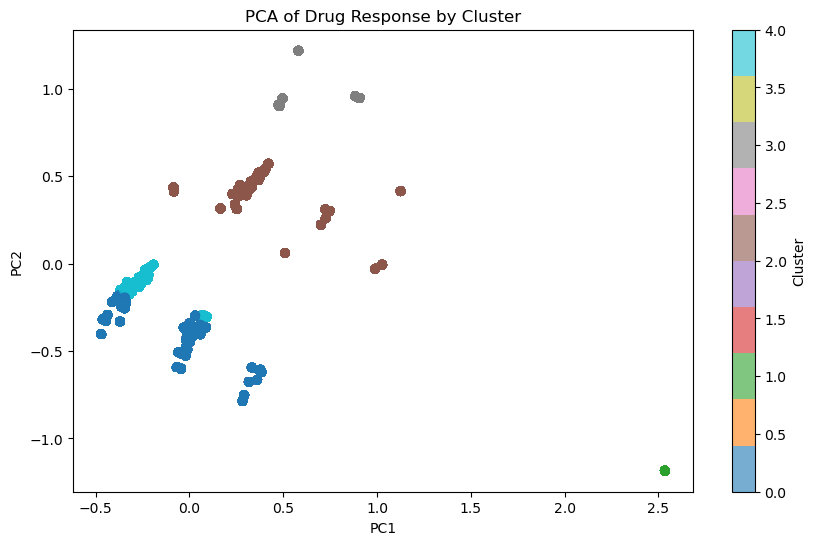

In [9]:
# k-means clustering based on PCA
from sklearn.cluster import KMeans

# Define the number of clusters
n_clusters = 5
# Create a KMeans instance with the desired number of clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
# Fit the KMeans model to the data
kmeans.fit(X_pca)
# Get the cluster labels
cluster_labels = kmeans.labels_
# Calculate silhouette score
silhouette_avg = silhouette_score(X_pca, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")
# Add cluster labels to the original DataFrame
data_filtered['Cluster'] = cluster_labels
# Plot PCA results with cluster labels
plt.figure(figsize=(10, 6))
plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=data_filtered['Cluster'], 
    cmap='tab10', 
    alpha=0.6
)
plt.title('PCA of Drug Response by Cluster')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
X_encoder.get_feature_names_out()  

array(['GDSC Tissue descriptor 1_aero_dig_tract',
       'GDSC Tissue descriptor 1_bone', 'GDSC Tissue descriptor 1_breast',
       'GDSC Tissue descriptor 1_digestive_system',
       'GDSC Tissue descriptor 1_kidney',
       'GDSC Tissue descriptor 1_large_intestine',
       'GDSC Tissue descriptor 1_leukemia',
       'GDSC Tissue descriptor 1_lung',
       'GDSC Tissue descriptor 1_lung_NSCLC',
       'GDSC Tissue descriptor 1_lung_SCLC',
       'GDSC Tissue descriptor 1_lymphoma',
       'GDSC Tissue descriptor 1_myeloma',
       'GDSC Tissue descriptor 1_nervous_system',
       'GDSC Tissue descriptor 1_neuroblastoma',
       'GDSC Tissue descriptor 1_pancreas',
       'GDSC Tissue descriptor 1_skin',
       'GDSC Tissue descriptor 1_soft_tissue',
       'GDSC Tissue descriptor 1_thyroid',
       'GDSC Tissue descriptor 1_urogenital_system',
       'GDSC Tissue descriptor 1_nan',
       'GDSC Tissue descriptor 2_B_cell_leukemia',
       'GDSC Tissue descriptor 2_B_cell_lymphoma',
 

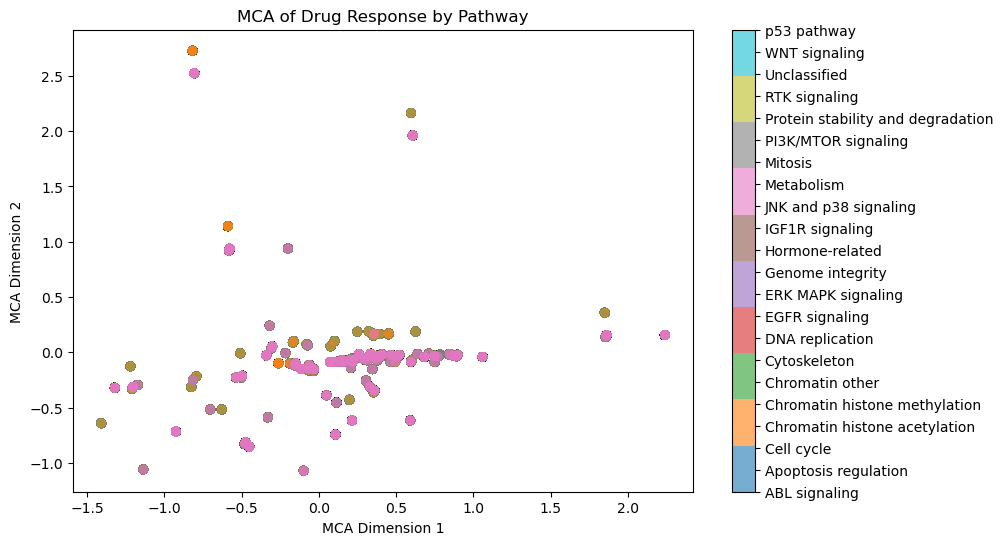

In [22]:
import prince
import pandas as pd
import matplotlib.pyplot as plt

# apply MCA
mca = prince.MCA(n_components=2, random_state=42)
mca_result = mca.fit_transform(X)

# capture the categorical variable
pathway_cat = pd.Categorical(data_filtered['TARGET_PATHWAY'])

# convert MCA result to DataFrame
mca_result.columns = ['Dim1', 'Dim2']
mca_result['ClusterCode'] = pathway_cat.codes
mca_result

# disply the first 5 rows
plt.figure(figsize=(10,6))
sc = plt.scatter(
    mca_result['Dim1'],
    mca_result['Dim2'],
    c=mca_result['ClusterCode'],
    cmap='tab10',
    alpha=0.6
)

# add color bar
cbar = plt.colorbar(sc, ticks=range(len(pathway_cat.categories)))
cbar.ax.set_yticklabels(pathway_cat.categories)

plt.title('MCA of Drug Response by Pathway')
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')
plt.show()

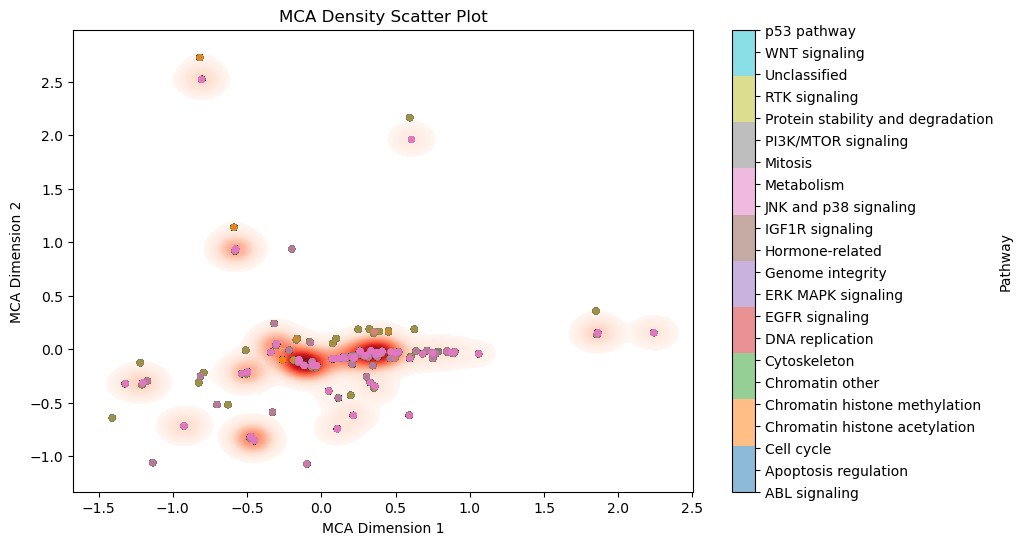

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

# density plot
sns.kdeplot(
    x=mca_result['Dim1'], 
    y=mca_result['Dim2'],
    cmap="Reds", 
    fill=True, 
    thresh=0.05, 
    levels=100,
    alpha=0.7
)

# scatter plot
sc = plt.scatter(
    mca_result['Dim1'], 
    mca_result['Dim2'],
    c=mca_result['ClusterCode'],
    cmap='tab10',
    s=15,
    alpha=0.5
)

# add color bar corresponding to pathway categories
cbar = plt.colorbar(sc, ticks=range(len(pathway_cat.categories)))
cbar.ax.set_yticklabels(pathway_cat.categories)
cbar.set_label('Pathway')

plt.title('MCA Density Scatter Plot')
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')

plt.show()


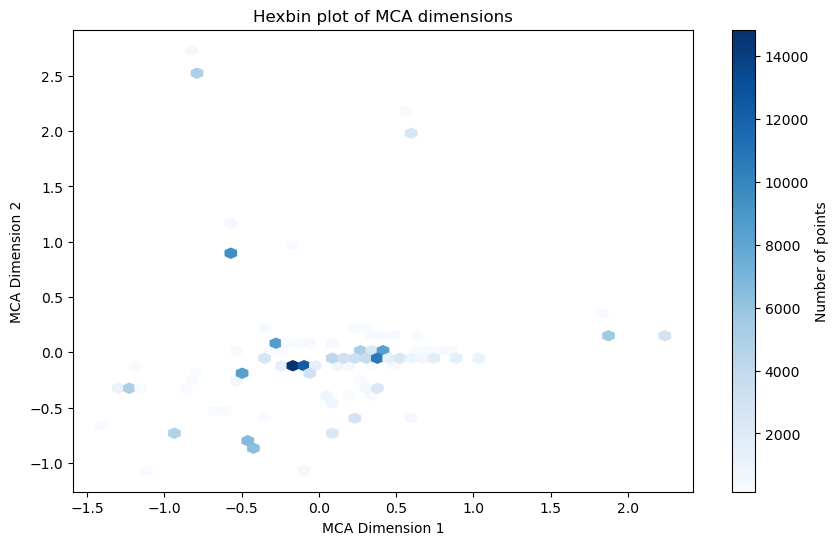

In [25]:
plt.figure(figsize=(10, 6))
# hexbin plot
plt.hexbin(
    mca_result['Dim1'], 
    mca_result['Dim2'], 
    gridsize=50, 
    cmap='Blues', 
    mincnt=1
)
# add color bar
plt.colorbar(label='Number of points')
plt.title('Hexbin plot of MCA dimensions')
plt.xlabel('MCA Dimension 1')
plt.ylabel('MCA Dimension 2')
plt.show()


In [27]:
col_coords = mca.column_coordinates(X)
col_coords.columns = ['Dim1', 'Dim2']

# show the top 10 most important features in each dimension
print(col_coords.sort_values('Dim1', ascending=False).head(10))
print(col_coords.sort_values('Dim2', ascending=False).head(10))

                                                    Dim1      Dim2
GDSC Tissue descriptor 1__large_intestine       2.927183  0.239714
Cancer Type (matching TCGA label)__COAD/READ    2.927183  0.239714
GDSC Tissue descriptor 2__large_intestine       2.927183  0.239714
Microsatellite instability Status (MSI)__MSI-H  1.643303 -0.001496
Cancer Type (matching TCGA label)__UCEC         1.380611 -0.057309
GDSC Tissue descriptor 2__endometrium           1.281069 -0.068635
Cancer Type (matching TCGA label)__PRAD         1.024108 -0.010815
GDSC Tissue descriptor 1__thyroid               0.978889  3.006508
Cancer Type (matching TCGA label)__THCA         0.978889  3.006508
GDSC Tissue descriptor 2__thyroid               0.978889  3.006508
                                                        Dim1      Dim2
Cancer Type (matching TCGA label)__NB              -1.217420  3.867512
GDSC Tissue descriptor 1__neuroblastoma            -1.217420  3.867512
GDSC Tissue descriptor 2__neuroblastoma           

## Visualize result

/var/folders/jh/t0y47tb93ylbfngjm_ry4rdr0000gn/T/ipykernel_2537/1972899312.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(models, rotation=30, ha='right')
/var/folders/jh/t0y47tb93ylbfngjm_ry4rdr0000gn/T/ipykernel_2537/1972899312.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(models, rotation=30, ha='right')


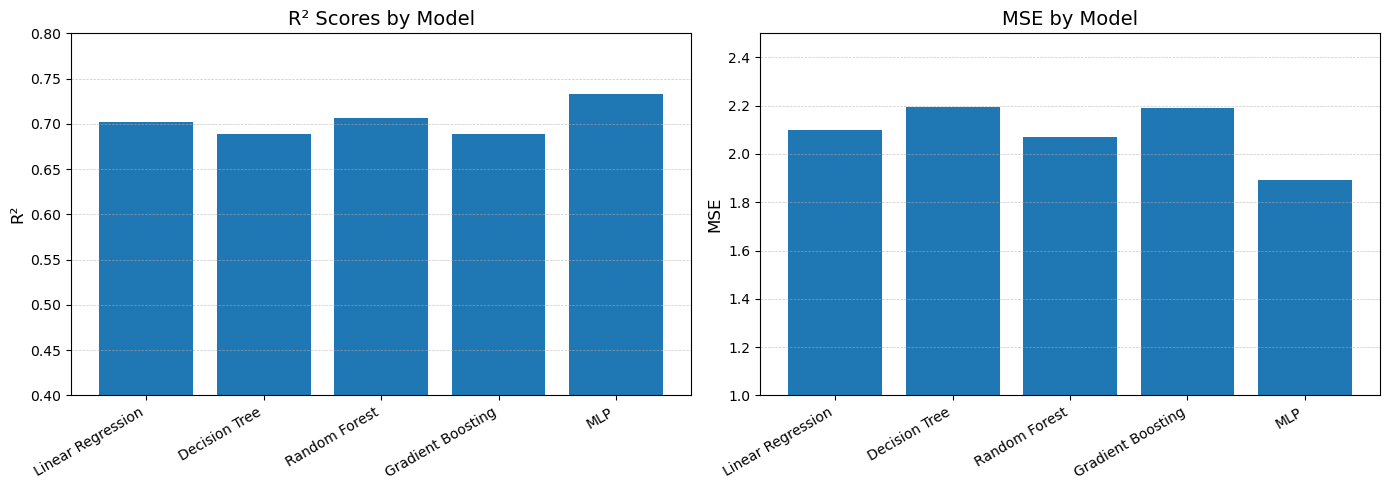

In [27]:
import matplotlib.pyplot as plt

# Data
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'MLP']
r2_scores = [0.7024, 0.6885, 0.7063, 0.6892, 0.7333]
mses = [2.0986, 2.1966, 2.0713, 2.1917, 1.8916]

# Custom colors for each model
colors = ['skyblue', 'lightgreen', 'salmon', 'plum', 'orange']

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=False)

# R² bar chart with custom colors
axes[0].bar(models, r2_scores)
axes[0].set_title('R\u00b2 Scores by Model', fontsize=14)
axes[0].set_ylabel('R\u00b2', fontsize=12)
axes[0].set_ylim(0.4, 0.8)
axes[0].set_xticklabels(models, rotation=30, ha='right')
axes[0].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# MSE bar chart with the same custom colors
axes[1].bar(models, mses)
axes[1].set_title('MSE by Model', fontsize=14)
axes[1].set_ylabel('MSE', fontsize=12)
axes[1].set_ylim(1, 2.5)
axes[1].set_xticklabels(models, rotation=30, ha='right')
axes[1].grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


## PCA and Contribution

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def center_data(X: pd.DataFrame) -> np.ndarray:
    return X.values - X.values.mean(axis=0)

def compute_covariance(X_centered: np.ndarray) -> np.ndarray:
    return np.cov(X_centered, rowvar=False)

def pca_eigen_decomp(cov: np.ndarray) -> (np.ndarray, np.ndarray):
    eigvals, eigvecs = np.linalg.eigh(cov)
    idx = np.argsort(eigvals)[::-1]
    return eigvals[idx], eigvecs[:, idx]

def get_loadings(eigvecs: np.ndarray, feature_names: pd.Index, n_components: int = 2) -> pd.DataFrame:
    pcs = [f'PC{i+1}' for i in range(n_components)]
    return pd.DataFrame(eigvecs[:, :n_components], index=feature_names, columns=pcs)

def get_top_n(loadings: pd.DataFrame, pc: str, n: int = 10) -> pd.Series:
    return loadings[pc].abs().nlargest(n)

def plot_top_loadings(top_series: dict):
    num_pcs = len(top_series)
    fig, axes = plt.subplots(1, num_pcs, figsize=(6 * num_pcs, 6))
    if num_pcs == 1:
        axes = [axes]
    for ax, (pc, series) in zip(axes, top_series.items()):
        series.sort_values().plot.barh(ax=ax, title=f'{pc} Top {len(series)} Loadings')
    plt.tight_layout()
    plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
===== Top 10 features contributing to PC1 =====


,abs_loading
Screen Medium_R,0.518214
Screen Medium_D/F12,0.518214
Growth Properties_Adherent,0.397913
Growth Properties_Suspension,0.378235
GDSC Tissue descriptor 1_leukemia,0.150538
GDSC Tissue descriptor 1_lymphoma,0.096828
GDSC Tissue descriptor 2_B_cell_lymphoma,0.090944
Cancer Type (matching TCGA label)_DLBC,0.090944
TCGA_DESC_DLBC,0.090944
GDSC Tissue descriptor 1_urogenital_system,0.086380



===== Top 10 features contributing to PC2 =====


,abs_loading
Screen Medium_R,0.373057
Screen Medium_D/F12,0.373057
Growth Properties_Adherent,0.349873
Growth Properties_Suspension,0.335904
GDSC Tissue descriptor 1_lung_NSCLC,0.293936
GDSC Tissue descriptor 2_lung_NSCLC_adenocarcinoma,0.254500
TCGA_DESC_LUAD,0.254500
Cancer Type (matching TCGA label)_LUAD,0.254500
TCGA_DESC_SCLC,0.179730
Cancer Type (matching TCGA label)_SCLC,0.179730


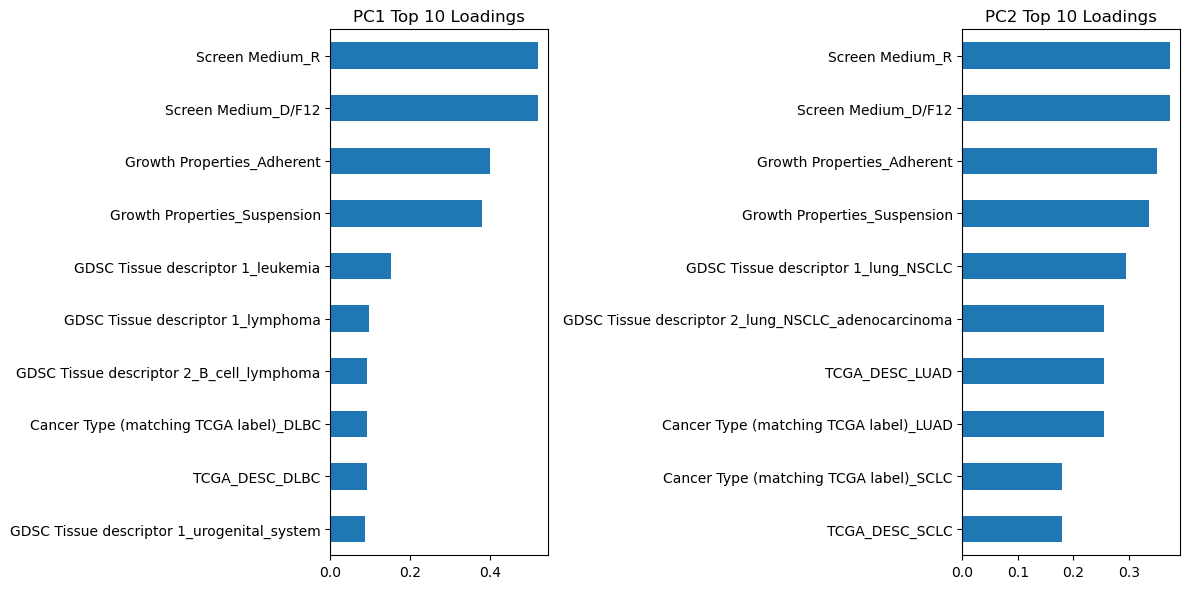

In [23]:
X_centered = center_data(Xd_tr)

# calculate covariance matrix
cov_matrix = compute_covariance(X_centered)

# get eigenvalues and eigenvectors
eigvals, eigvecs = pca_eigen_decomp(cov_matrix)

# build loadings DataFrame
loadings_df = get_loadings(eigvecs, Xd_tr.columns, n_components=2)

# get top 10 features for each PC
top10_pc1 = get_top_n(loadings_df, 'PC1', n=10)
top10_pc2 = get_top_n(loadings_df, 'PC2', n=10)

print("===== Top 10 features contributing to PC1 =====")
display(top10_pc1.to_frame(name='abs_loading'))

print("\n===== Top 10 features contributing to PC2 =====")
display(top10_pc2.to_frame(name='abs_loading'))

# (7) Visualize
plot_top_loadings({'PC1': top10_pc1, 'PC2': top10_pc2})


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


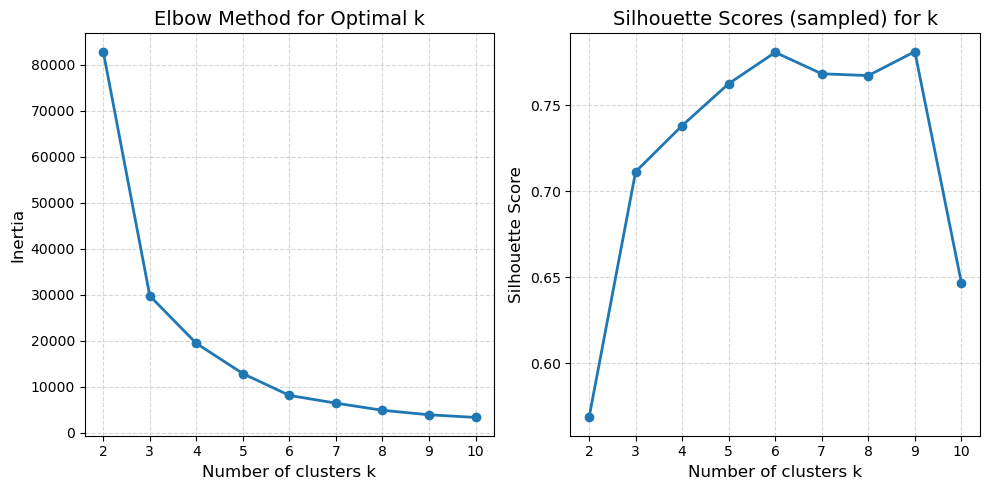

In [24]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from matplotlib.ticker import MaxNLocator
from joblib import parallel_backend
import numpy as np

data_for_clustering = X_pca

max_k = 10
ks = list(range(2, max_k + 1))
inertias = []
sil_scores = []

# define sample size for silhouette
sample_size = 10_000
rng = np.random.RandomState(42)

for k in ks:
    # 2) run KMeans in a separate process to avoid in‑process threading conflicts
    with parallel_backend('loky', n_jobs=1):
        km = KMeans(n_clusters=k, n_init=10, max_iter=300, random_state=42)
        km.fit(data_for_clustering)
    inertias.append(km.inertia_)

    labels = km.labels_
    if len(data_for_clustering) > sample_size:
        idx = rng.choice(len(data_for_clustering), size=sample_size, replace=False)
        score = silhouette_score(data_for_clustering[idx], labels[idx], random_state=42)
    else:
        score = silhouette_score(data_for_clustering, labels, random_state=42)
    sil_scores.append(score)

# Plotting the Elbow Method and Silhouette Score
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharey=False)

# left figure：Elbow Method 
axes[0].plot(ks, inertias, 'o-', linewidth=2)
axes[0].set_title('Elbow Method for Optimal k', fontsize=14)
axes[0].set_xlabel('Number of clusters k', fontsize=12)
axes[0].set_ylabel('Inertia', fontsize=12)
axes[0].set_xticks(ks)
axes[0].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[0].grid(True, linestyle='--', alpha=0.5)

# right figure：Silhouette Score
axes[1].plot(ks, sil_scores, 'o-', linewidth=2)
axes[1].set_title('Silhouette Scores (sampled) for k', fontsize=14)
axes[1].set_xlabel('Number of clusters k', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_xticks(ks)
axes[1].xaxis.set_major_locator(MaxNLocator(integer=True))
axes[1].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


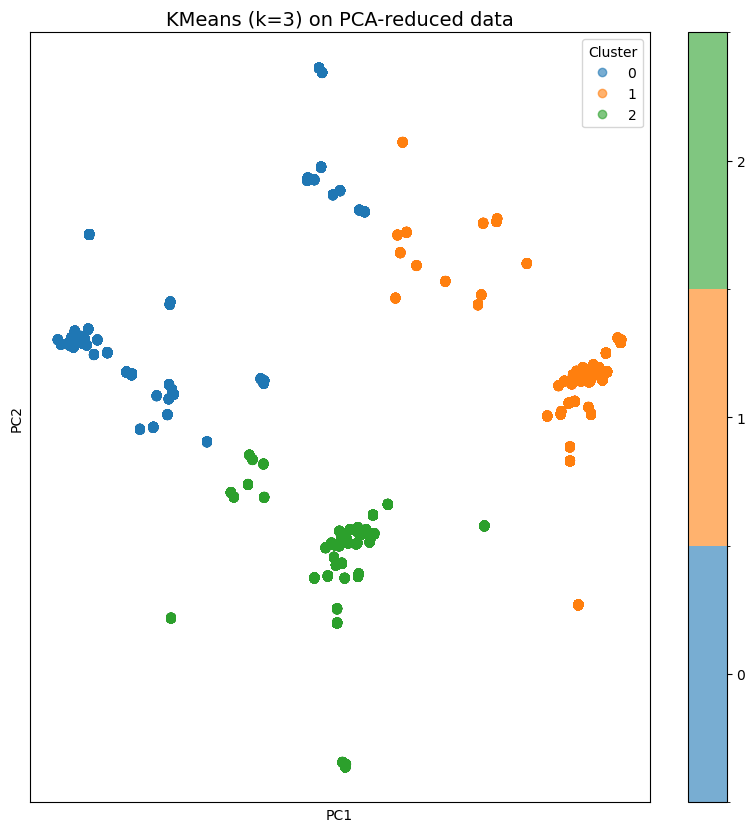

In [36]:
from matplotlib.colors import ListedColormap, BoundaryNorm
Xc   = center_data(X_dummy)
cov  = compute_covariance(Xc)
_, eigvecs = pca_eigen_decomp(cov)

scores = Xc.dot(eigvecs[:, :2])
best_k = 3
labels = KMeans(n_clusters=best_k, random_state=42).fit_predict(scores)

df = pd.DataFrame(scores, columns=['PC1','PC2'], index=X_dummy.index)
df['Cluster'] = labels

cmap = ListedColormap(['tab:blue', 'tab:orange', 'tab:green'])
cbar.ax.set_yticklabels(['Cluster 0','Cluster 1','Cluster 2'])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5], ncolors=cmap.N)
plt.figure(figsize=(10,10))
scat = plt.scatter(df['PC1'], df['PC2'], c=df['Cluster'], alpha=0.6, cmap=cmap, norm=norm)
cbar = plt.colorbar(scat, ticks=[0,1,2])
plt.legend(*scat.legend_elements(), title="Cluster")
plt.title('KMeans (k=3) on PCA-reduced data', fontsize=14)
plt.xticks([]); plt.yticks([])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()
